# NLP

Analyse des reviews que des utilisateurs laissent sur les apps de rencontre hébergées sur les App stores.
Le dataset dont nous allons nous servir est issu de kaggle:  https://www.kaggle.com/sidharthkriplani/datingappreviews.

## Import des librairies

Nous aurons besoin de scikit-learn, pandas, numpy et ntlk la librairie d'analyse de langage naturel.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
#NLP libs
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Préparation des données

Le dataset n'est pas encore propre et il faut le traiter avant toute chose.

### Nettoyage

- Gérer les NaNs (les remplacer par des valeurs qui ont du sens ou tout simplement supprimer la ligne pour les données critiques)
- S'assurer d'avoir un index unique pour chaque ligne
- 

In [174]:
df = pd.read_csv("./DatingAppReviewsDataset.csv", index_col=0)
df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder


In [175]:
print("On vérifie que les index sont bien des valeurs uniques: ", df.index.is_unique)

print("On va donc réécrire cet index.")
df = df.reset_index()
df = df.drop("index", axis = 1)

print("On va regarder si des NaNs existent dans le dataset")
print(df.isna().any())
print("Name et Review contiennent des NaNs on va donc les nettoyer")

On vérifie que les index sont bien des valeurs uniques:  False
On va donc réécrire cet index.
On va regarder si des NaNs existent dans le dataset
Name          True
Review        True
Rating       False
#ThumbsUp    False
Date&Time    False
App          False
dtype: bool
Name et Review contiennent des NaNs on va donc les nettoyer


In [176]:
#On supprime les rows si Review, Rating ou App sont des nan. Des lignes avec #ThumbsUp,	Date&Time et Name étant des NAN existent 
# mais leur impact est limité dans notre analyse 

df.dropna(inplace=True, subset=["Review", "Rating", "App"])
df["Name"].fillna("Not available", inplace=True)

print(df.isna().any())
print("On n'a plus aucun NaNs et on s'est débarrasé des rows ayant des reviews vides.")

Name         False
Review       False
Rating       False
#ThumbsUp    False
Date&Time    False
App          False
dtype: bool
On n'a plus aucun NaNs et on s'est débarrasé des rows ayant des reviews vides.


### Exploration des données

Ici on va tracer des courbes en essayant de faire parler les données. Il s'agit d'une analyse exploratoire.

,#ThumbsUp
Rating,
0,0
1,825165
2,184295
3,98943
4,82624
5,86775


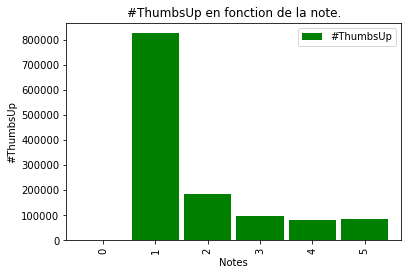

Les commentaires ayant reçu une note de 1 sont les plus souvent upvotés et de loin.


In [177]:
#Dataframe contenant la somme des thumbs up pour chaque note attribuée aux commentaires
comp_rating_thumbs_up = df.groupby("Rating").sum()
display(comp_rating_thumbs_up)

#On reset l'index car rating a été considéré comme l'index:
comp_rating_thumbs_up.reset_index().plot.bar(x="Rating", y="#ThumbsUp", width=0.9, color="g")

plt.xlabel("Notes")
plt.ylabel("#ThumbsUp")
plt.title("#ThumbsUp en fonction de la note.");
plt.show();

print("Les commentaires ayant reçu une note de 1 sont les plus souvent upvotés et de loin.")

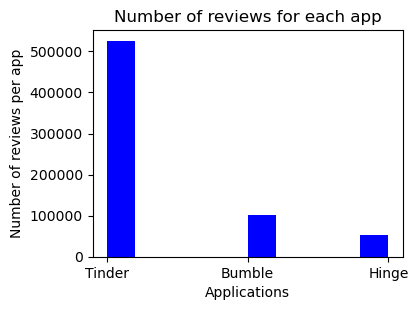

Tinder est l'application la plus notée


In [178]:
plt.figure(dpi=100, figsize=(4,3))
plt.hist(df.App, color="blue", stacked=True)
plt.xlabel("Applications")
plt.ylabel("Number of reviews per app")
plt.title("Number of reviews for each app")
plt.show();
print("Tinder est l'application la plus notée")


Rating                     
          min max      mean median
App                               
Bumble      1   5  2.832252    3.0
Hinge       1   5  3.180895    4.0
Tinder      0   5  3.007847    3.0

Hinge est l'application qui possède le la note moyenne la plus élevée. Néanmoins c'est aussi celle qui a le moins de reviews.
Avec un si petit delta dans la note moyenne associée aux apps, la note moyenne de Tinder, ayant 4 fois plus de reviews que Hinge est plus fiable.


On affiche les notes moyennes des différentes applications:


App,Bumble,Hinge,Tinder
Rating,2.832252,3.180895,3.007847


On peut voir ici que l'application la mieux notée est Hinge car sa note moyenne est 3.18/5


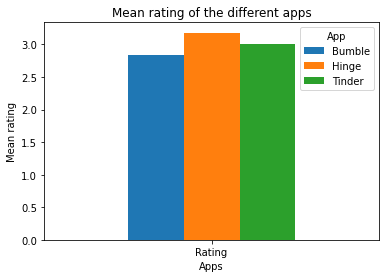

In [179]:
display(df.groupby("App").agg({"Rating": [min, max, np.mean, np.median]}))
print("Hinge est l'application qui possède le la note moyenne la plus élevée. Néanmoins c'est aussi celle qui a le moins de reviews.")
print("Avec un si petit delta dans la note moyenne associée aux apps, la note moyenne de Tinder, ayant 4 fois plus de reviews que Hinge est plus fiable.")

print("\n\nOn affiche les notes moyennes des différentes applications:")
mean_rating_df = df.groupby("App").agg({"Rating": np.mean}).T
display(mean_rating_df)

mean_rating_df.plot.bar(rot=0)

plt.title("Mean rating of the different apps")
plt.xlabel("Apps")
plt.ylabel("Mean rating")

print("On peut voir ici que l'application la mieux notée est Hinge car sa note moyenne est 3.18/5")

On regarde quelle est la répartition des notes dans le jeu de données

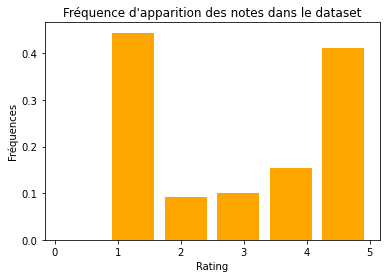

On observe une prépondérence de 1 et de 5 ce qui portent à croire que les utilisateurs sont soit très contents soit très mécontents de l'application.


In [181]:
plt.hist(df.Rating, density=True, bins=6, rwidth=0.8, color="orange")
plt.xlabel("Rating")
plt.ylabel("Fréquences")
plt.title("Fréquence d'apparition des notes dans le dataset")
plt.show();

print("On observe une prépondérence de 1 et de 5 ce qui portent à croire que les utilisateurs sont soit très contents soit très mécontents de l'application.")

### Pré-analyse des du texte des reviews

On va analyser ici les nombres de mots de chaque review et en déduire des tendances quant à la verbosité des utilisateurs en fonction de la note associée à la review

In [182]:
#On compte les mots et on ajoute une colonne contenant ce nombre dans le dataframe initial.
df['word_count'] = df['Review'].apply(lambda x: len(str(x).split()))

print("Nombres de mots MOYENS pour les reviews ayant été notées:")
print("\t- Note 0/5:", np.round(df[df['Rating']==0]['word_count'].mean()), "mots.") #rating 0
print("\t- Note 1/5:", np.round(df[df['Rating']==1]['word_count'].mean()), "mots.") #rating 1
print("\t- Note 2/5:", np.round(df[df['Rating']==2]['word_count'].mean()), "mots.") #rating 2
print("\t- Note 3/5:", np.round(df[df['Rating']==3]['word_count'].mean()), "mots.") #rating 3
print("\t- Note 4/5:", np.round(df[df['Rating']==4]['word_count'].mean()), "mots.") #rating 4
print("\t- Note 5/5:", np.round(df[df['Rating']==5]['word_count'].mean()), "mots.") #rating 5


print("\nNombres de mots MEDIANS pour les reviews ayant été notées:")
print("\t- Note 0/5:", np.round(df[df['Rating']==0]['word_count'].median()), "mots.") #rating 0
print("\t- Note 1/5:", np.round(df[df['Rating']==1]['word_count'].median()), "mots.") #rating 1
print("\t- Note 2/5:", np.round(df[df['Rating']==2]['word_count'].median()), "mots.") #rating 2
print("\t- Note 3/5:", np.round(df[df['Rating']==3]['word_count'].median()), "mots.") #rating 3
print("\t- Note 4/5:", np.round(df[df['Rating']==4]['word_count'].median()), "mots.") #rating 4
print("\t- Note 5/5:", np.round(df[df['Rating']==5]['word_count'].median()), "mots.") #rating 5
print("Les reviews notées 4/5 et 5/5 ont une sur-représentation de reviews possédant moins de 3 mots (sans doute des emojis).")


Nombres de mots MOYENS pour les reviews ayant été notées:
	- Note 0/5: 19.0 mots.
	- Note 1/5: 24.0 mots.
	- Note 2/5: 27.0 mots.
	- Note 3/5: 20.0 mots.
	- Note 4/5: 13.0 mots.
	- Note 5/5: 7.0 mots.

Nombres de mots MEDIANS pour les reviews ayant été notées:
	- Note 0/5: 19.0 mots.
	- Note 1/5: 16.0 mots.
	- Note 2/5: 20.0 mots.
	- Note 3/5: 13.0 mots.
	- Note 4/5: 7.0 mots.
	- Note 5/5: 3.0 mots.
Les reviews notées 4/5 et 5/5 ont une sur-représentation de reviews possédant moins de 3 mots (sans doute des emojis).


On va représenter graphiquement ces observations:


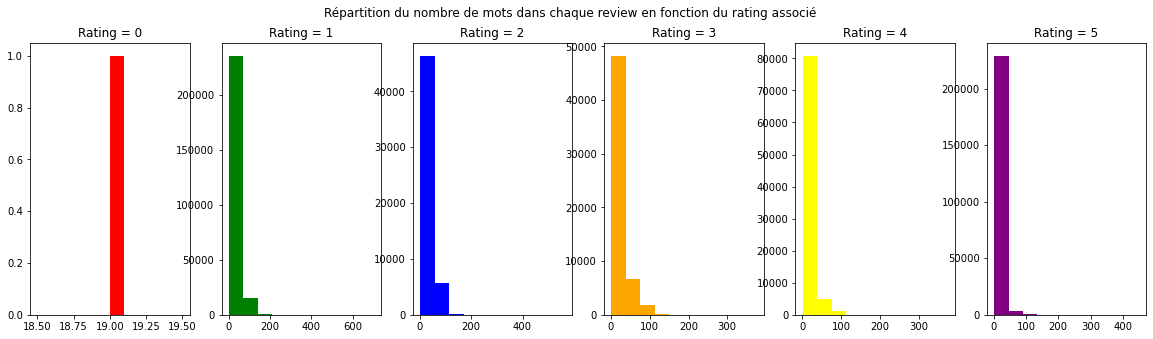

On voit ici que le moyennes du nombre de mots pour chaque review sont lourdement impactées par les commentaires qui possèdent moins de 3 mots.


In [183]:
print("On va représenter graphiquement ces observations:")

fig,(ax1,ax2, ax3, ax4, ax5, ax6)=plt.subplots(1, 6, figsize=(20,5))

train_words=df[df['Rating']==0]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Rating = 0')

train_words=df[df['Rating']==1]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Rating = 1')

train_words=df[df['Rating']==2]['word_count']
ax3.hist(train_words,color='blue')
ax3.set_title('Rating = 2')

train_words=df[df['Rating']==3]['word_count']
ax4.hist(train_words,color='orange')
ax4.set_title('Rating = 3')

train_words=df[df['Rating']==4]['word_count']
ax5.hist(train_words,color='yellow')
ax5.set_title('Rating = 4')

train_words=df[df['Rating']==5]['word_count']
ax6.hist(train_words,color='purple')
ax6.set_title('Rating = 5')

fig.suptitle("Répartition du nombre de mots dans chaque review en fonction du rating associé")
plt.show();

print("On voit ici que le moyennes du nombre de mots pour chaque review sont lourdement impactées par les commentaires qui possèdent moins de 3 mots.")


### Analyse temporelle du jeu de données

J'ai trouvé sur internet, une anlalyse pertinente à faire avec ce genre de jeu de données: la part de marché de chaque application en fonction des années, basée sur le nombre de review laissées, c'est ce que nous allons faire ici:

In [205]:
#On change le format de la date fourni dans le dataframe initial
df['Date&Time'] = pd.to_datetime(df['Date&Time'], format="%d-%m-%Y %H:%M")

bins=[2013,2015,2017,2019,2021,2022]
labels=['2013-2014', '2015-2016', '2017-2018','2019-2020','2021-2022']
df_gb_year = df.groupby(by=pd.cut(df['Date&Time'].dt.year, bins=bins, labels=labels))

df_by_year = list(df_gb_year)
subplot_titles = [item[0] for item in df_by_year]

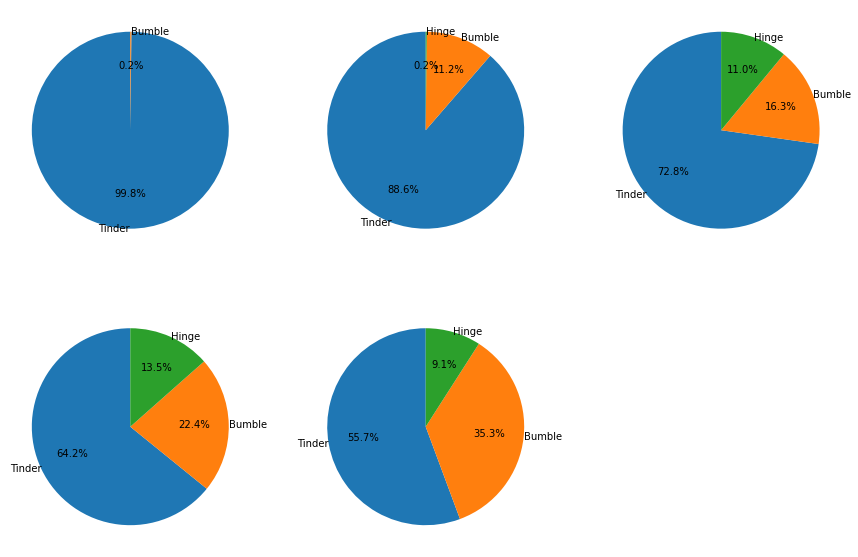

In [243]:
plt.figure(figsize=(15, 10))
for index, item in enumerate(df_by_year):
    position = int("23" + str(index+1))
    plt.subplot(position)
    slice = item[1]['App'].value_counts().to_frame().reset_index().rename(columns={"index": "App", "App": "#Reviews"})
    plt.pie(x = slice["#Reviews"], labels=slice["App"], labeldistance = 1, autopct='%1.1f%%', startangle=140, pctdistance=0.65, radius = 1)


### Séparation des variables et balance des données

On sépare ici le jeu de données en 2 afin d'extraire les variables explicatives de la variable cible. 

Notre variable explicative est ici "Review" et la variable cible est "Rating"

In [105]:
print("On est surtout intéressés par les Reviews et la note associée donc on drop les colonnes qui ne nous servent pas.")
#X = df.drop(["Rating", "#ThumbsUp", "Name", "Date&Time", "App" ], axis = 1)
X = df.Review
y = df.Rating

On est surtout intéressés par les Reviews et la note associée donc on drop les colonnes qui ne nous servent pas.
